Autoencoder Anomaly Testing
===

This is rebuilt from the "Collecting Network Statistics" notebook. The goal of this notebook is to collect together a set of in-distribution and out-of-distribution images and confirm that the model can distinguish them with a high degree of accuracy.


## Setup

We begin by importing our dependencies.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import math

from pytorch_msssim import ssim,ms_ssim,SSIM
from model import SplitAutoencoder,ExtensibleEncoder,ExtensibleDecoder
from CustomDataSet import CustomDataSet,CustomDataSetWithError
import os

import GPUtil

Set our seed and other configurations for reproducibility.

In [2]:
seed = 42
#seed = 2662
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

if torch.cuda.is_available():
    platform = "cuda"
else:
    platform = "cpu"
#platform = "cpu"
print(platform)

cuda


We set the batch size, the number of training epochs, and the learning rate. Batch size has to be reasonably low as we can't fit a huge number of these images into VRAM on my laptop.

Image size can be set here as I'm automatically resizing the images in my extraction code.

In [3]:
width = 256
height = 256

image_size = width * height

batch_size = 1

#meta-parameters
l2_decay = 0.0
dropout_rate = 0.0
code_sides = [20]
convolution_filters = 32

model_path = "../../Data/OPTIMAM_NEW/model" + str(width) + "_" + str(code_sides[0]) + "_" + str(convolution_filters) + "_" + str(dropout_rate) + "_" + str(l2_decay) + ".pt"

#image_count = 500
image_count = -1

validation_split = 0.95

## Gather Base Distribution Information

First we run the model on the entire original distribution and gather statistics on the loss values, encodings etc.

In [4]:
from torchvision.transforms import ToTensor,Normalize
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.0,65535.0)
    ])

root_dir = "../../Data/OPTIMAM_NEW/png_images/casewise/ScreeningMammography/" + str(width)
train_dataset = CustomDataSet(root_dir, transform)

if (image_count == -1):
    train_dataset_subset = train_dataset
    image_count = len(train_dataset)
else:
    train_dataset_subset = torch.utils.data.Subset(train_dataset, numpy.random.choice(len(train_dataset), image_count, replace=False))

train_subset_idx = np.random.choice(len(train_dataset), int(image_count * validation_split), replace=False)

n = np.arange(len(train_dataset))
mask = np.ones(len(train_dataset), dtype=bool)
mask[train_subset_idx] = False
holdout_subset_idx = n[mask]

dataset_size = len(train_dataset_subset)
      
t_subset = torch.utils.data.Subset(train_dataset_subset, train_subset_idx)

train_loader = torch.utils.data.DataLoader(
    t_subset, batch_size=batch_size, shuffle=False
)

h_subset = torch.utils.data.Subset(train_dataset_subset, holdout_subset_idx)

holdout_loader = torch.utils.data.DataLoader(
    h_subset, batch_size=batch_size, shuffle=False
)

In [5]:
print(train_subset_idx)
print(holdout_subset_idx)

[  88   85   94 ...  693 1323  867]
[  18   38   45   71  101  125  155  158  163  168  185  217  235  283
  286  293  320  347  354  359  367  386  397  414  429  444  472  485
  521  529  552  571  587  654  676  679  712  722  724  762  782  804
  807  812  834  883  892  921  937  950  951  963  976  979  998 1004
 1008 1014 1026 1066 1104 1124 1136 1143 1163 1167 1187 1198 1225 1230
 1245 1282 1284 1306 1313 1315 1316 1325 1364 1382 1399 1412 1429 1431
 1452 1480 1486 1491 1500 1507 1547 1554 1590 1599 1606 1622 1626 1631
 1632 1643 1656 1668 1700 1704 1717 1729 1742 1751 1754 1778 1794 1805
 1820 1933 1946 1969 1981 1989 2007 2025 2088 2124 2144 2188 2210 2215
 2274 2304 2349 2368 2430 2453 2456 2467 2472 2513 2515 2518 2529 2584
 2637 2652 2653 2657 2670 2685 2696 2714 2722 2723 2735 2750 2769 2774
 2788 2809 2856 2884 2917 2932 2956 2957 2961 2962 2987 3013 3017 3034
 3242 3254 3274 3297 3364 3402 3404 3430 3440 3486 3508 3544 3613 3625
 3637 3647]


In [6]:
#  use gpu if available
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device(platform)

code_size = code_sides[0] * code_sides[0]

# mean-squared error loss
criterion = nn.MSELoss()

features = [None] * len(t_subset)
losses = [None] * len(t_subset)
encodings = [None] * len(t_subset)
outputs = [None] * len(t_subset)

In [7]:
# reload the saved model
model = torch.load(model_path,map_location=device)
model.eval()

SplitAutoencoder(
  (encoder): ExtensibleEncoder(
    (cnnStage): Sequential(
      (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout2d(p=0.0, inplace=True)
      (relu1): ReLU()
      (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout2): Dropout2d(p=0.0, inplace=True)
      (relu2): ReLU()
      (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout3): Dropout2d(p=0.0, inplace=True)
      (relu3): ReLU()
      (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (fc1): Linear(in_features=131072, out_features=400, bias=True)
  )
  (decoder): ExtensibleDecoder(
    (cnnStage): Sequential(


We run our autoencoder on the entire dataset and store the encodings

In [8]:
with torch.no_grad():
    count = 0
    for batch_features in train_loader:
        # load it to the active device
        batch_features = batch_features.to(device)

        features[count] = batch_features.cpu()
        
        # compute reconstructions
        code = model.encoder(batch_features)
        output = model.decoder(code)
        
        outputs[count] = output.cpu()
        
        code_reshaped = code.detach().cpu().numpy()[0]
        code_reshaped.reshape(code_size)

        encodings[count] = code_reshaped

        # compute training reconstruction loss
        error_criterion = criterion(output,batch_features)

        losses[count] = error_criterion.cpu().numpy()

        count = count + 1

C:\Users\chali\Miniconda3\envs\pytorch\lib\site-packages\torchvision\transforms\functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
C:\Users\chali\Miniconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


And calculate the encoding statistics:

In [9]:
print(len(encodings))
print(len(encodings[0]))
print(len(losses))

3493
400
3493


In [10]:
mse_min = np.amin(losses)
mse_max = np.amax(losses)
mse_mean = np.mean(losses)
mse_std = np.std(losses)
print("MSE Min/Mean/Max/SD:" + str(mse_min) + "/" + str(mse_mean) + "/" + str(mse_max) + "/" + str(mse_std)   )

MSE Min/Mean/Max/SD:0.00028661938/0.002766253/0.062827215/0.002123605


In [11]:
features_n = np.stack(features)
outputs_n = np.stack(outputs)
print(features_n.shape)
print(outputs_n.shape)

pre_ssims = [None] * image_count

ssim_module = SSIM(data_range=1.0, size_average=False, channel=3)

for i in range(image_count-1):
    features_s = features_n[i].reshape(1,1,height,width).repeat(3,1)
    outputs_s = outputs_n[i].reshape(1,1,height,width).repeat(3,1)
    ssim_f = ssim_module(torch.from_numpy(features_s), torch.from_numpy(outputs_s))
    pre_ssims[i] = ssim_f.item()
    
ssim_min = np.amin(pre_ssims)
ssim_max = np.amax(pre_ssims)
ssim_mean = np.mean(pre_ssims)
ssim_sd = np.std(pre_ssims)
print("SSIM Min/Mean/Max/SD:" + str(ssim_min) + "/" + str(ssim_mean) + "/" + str(ssim_max) + "/" + str(ssim_sd))

(3493, 1, 1, 256, 256)
(3493, 1, 1, 256, 256)


IndexError: index 3493 is out of bounds for axis 0 with size 3493

Now we save the compiled statistics to an excel file.

In [12]:
with torch.no_grad():
    np_losses = np.asarray(losses)
    #np_pre_ssims = np.asarray(pre_ssims)
    np_compiled = np.concatenate((np_losses[:, np.newaxis], encodings), axis=1)

    suffix =  "_" + str(width) + "_" + str(code_sides[0]) + "_" + str(convolution_filters) + "_" + str(dropout_rate) + "_" + str(l2_decay)
    
    np.savetxt('base_encodings' + suffix + '.csv', encodings, delimiter=',',fmt='%10.5f',newline='\n')
    np.savetxt('base_losses' + suffix + '.csv', np_losses, delimiter=',',fmt='%10.5f',newline='\n')
    #np.savetxt('base_ssim' + suffix + '.csv', np_losses, delimiter=',',fmt='%10.5f',newline='\n')
    np.savetxt('base_combined' + suffix + '.csv', np_compiled, delimiter=',',fmt='%10.5f',newline='\n')

## Adversarials

We have 2 Datasets (mammographic and non-mammographic) and 3 DataLoaders - Clean Mammo, Distorted Mammo, and Non-Mammo. The goal here is to build an analogously large set of OOD images and test to what degree the autoencoder is capable of detecting the distortions.

The first method for doing this builds a large set of all the datasets classified into In-Distribution and Out-Of-Distribution and determine the accuracy rating of the model as a classifier. The second generates a set of distorted mammographic images at specified distances from the distribution, along with a value roughly analogous to that distortion level. This second method is intended to determine the range in distribution space at which the model becomes able to distinguish, as well as the degree of "grey area" between in and out of distribution (as detected).

In [13]:
with torch.no_grad():
    trigger_chance = 0.4

    PIL_transforms = torchvision.transforms.RandomApply([
        torchvision.transforms.RandomAffine(degrees=10,translate=(0.2,0.2),shear=25),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.GaussianBlur(kernel_size=3),
        torchvision.transforms.ColorJitter(brightness=0.2,contrast=0.1)
        ],p=trigger_chance)
    
    tensor_transforms = torchvision.transforms.RandomApply([
        torchvision.transforms.RandomErasing(p=trigger_chance),
        torchvision.transforms.Lambda(lambda x : x + torch.randn_like(x))
        ],p=trigger_chance)

    adversarial_transform = torchvision.transforms.Compose([
        PIL_transforms,
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(0.0,1.0),
        tensor_transforms
        ])
   
    adversarial_image_count = image_count
    adversarial_dataset = CustomDataSetWithError(root_dir, adversarial_transform)
    
    a_subset = torch.utils.data.Subset(adversarial_dataset, holdout_subset_idx)

    adversarial_loader = torch.utils.data.DataLoader(
        a_subset,shuffle=True
    )
    
    

Build the first (mixed) set:

In [14]:
with torch.no_grad():
    adversarial_iterator = iter(adversarial_loader)
    genuine_iterator = iter(holdout_loader)
    mixed_set_scale = 300
    
    mixed_set = []
    mixed_set_np = []
    mixed_class_set = []
    mixed_error_set = []
    for i in range(mixed_set_scale):
        r = torch.rand(1)
        if(r.item() > 0.5):
            adversarial_t = next(adversarial_iterator)
            adversarial = adversarial_t[0].cpu()
            adversarial_np = adversarial.numpy().reshape(width,height)
            adv_error = adversarial_t[1]
            mixed_class_set.append(0)
            mixed_set_np.append(adversarial_np)
            mixed_set.append(adversarial)
            mixed_error_set.append(adv_error.item())
        else:
            genuine = next(genuine_iterator).cpu()
            genuine_np = genuine.numpy().reshape(width,height)
            mixed_class_set.append(1)
            mixed_set.append(genuine)
            mixed_set_np.append(genuine_np)
            mixed_error_set.append(0.0) # genuine, so no drift
        
    mixed_code_set = []
    mixed_reconstruction_set = []

Now run the model on the mixed set:

In [15]:
with torch.no_grad():
    for mixed_item in mixed_set:
        mixed_example = mixed_item.to(device)
        
        n_code = model.encoder(mixed_example)
        reconstruction = model(mixed_example)
        
        mixed_code_set.append(n_code.cpu())
        mixed_reconstruction_set.append(reconstruction.cpu())

Next, measure the loss and feature statistics for the adversarials:            

#### Mean Squared Error (MSE):

First calculate the MSE for all the reconstructed images.

In [16]:
mean_squared_errors = []

for image_n in range(mixed_set_scale):
    recon = mixed_reconstruction_set[image_n][0][0]
    original = mixed_set[image_n][0][0]
    t_se = 0.0
    q = []
    n = 0
    t_min = 65535.0
    t_max = 0.0
    for y in range(height):
        p = []
        for x in range(width):
            base_pixel = original[y][x].item()
            recon_pixel = recon[y][x].item()
            #specifically ignore all-black pixels
            if(base_pixel < t_min):
                t_min = base_pixel
            if(base_pixel > t_max):
                t_max = base_pixel
            se = (recon_pixel - base_pixel) ** 2
            p.append(se)
            t_se = t_se + se
            n = n + 1
        q.append(p)
    #print(q)
    
    mse = t_se / n
    
    mean_squared_errors.append(mse)
    
post_mse_min = np.amin(mean_squared_errors)
post_mse_max = np.amax(mean_squared_errors)
post_mse_mean = np.mean(mean_squared_errors)
post_mse_std = np.std(mean_squared_errors)
print("Prediction MSE Min/Mean/Max/SD:" + str(post_mse_min) + "/" + str(post_mse_mean) + "/" + str(post_mse_max) + "/" + str(post_mse_std))

Prediction MSE Min/Mean/Max/SD:0.0006097725052233201/54453914.95757456/391168864.44486564/96703055.9718091


And attempt to predict classes based on MSE:

In [17]:
mse_threshold = mse_mean + (2 * mse_std)

predicted_class = []
for i in range(mixed_set_scale):
    if(mean_squared_errors[i]<mse_threshold):
        predicted_class.append(1) # distribution
    else:
        predicted_class.append(0) # adversarial

mixed_class_np = np.asarray(mixed_class_set)
predicted_class_np = np.asarray(predicted_class)
print(mixed_class_np)
print(predicted_class_np)
matches = (mixed_class_np == predicted_class_np)
print(matches)
hits = np.count_nonzero(matches)
misses = mixed_set_scale - hits
accuracy = hits / mixed_set_scale
print("Accuracy:" + str(accuracy))

fails = np.where(matches==False)
print(fails)

[1 0 1 0 0 0 1 0 0 1 1 1 1 1 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 1 0 1 0
 1 1 0 1 1 0 1 1 1 1 0 0 0 0 0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 0 1 0
 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0
 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 0 1 1 0 0 1 1 0
 0 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 0 1 1 1 1 0 1 0 0 0 0 1 0 1 1 1
 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 1 0 1 1 1 0 0 1 0 0 0 1 0 0 1 1
 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 0 1
 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1 0 0 1
 1 1 0 1]
[1 0 1 0 0 0 1 0 0 1 1 1 1 1 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 1 0 1 0
 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 0 1 0
 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0
 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 0 1 1 0 0 1 1 0
 0 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 0 1 1 1 0 0 1 0 0 0 0 1 0 1 1 1
 1 0 0 0 0 1 0 

#### STRUCTURAL SIMILARITY INDEX (SSIM)

Generate RGB versions of the base and recreated images.

In [ ]:
mixed_set_s = np.stack(mixed_set).reshape(mixed_set_scale,1,height,width).repeat(3,1)
mixed_recon_s = np.stack(mixed_reconstruction_set).reshape(mixed_set_scale,1,height,width).repeat(3,1)
print(mixed_set_s.shape)
print(mixed_recon_s.shape)

And use that for Structural Similarity Index:

In [ ]:
ssim_t = ssim(torch.from_numpy(mixed_set_s), torch.from_numpy(mixed_recon_s), data_range=1.0, size_average = False)
ms_ssim_t = ms_ssim(torch.from_numpy(mixed_set_s), torch.from_numpy(mixed_recon_s), data_range=1.0, size_average = False)

In [ ]:
post_ssim_min = np.amin(ssim_t.numpy())
post_ssim_max = np.amax(ssim_t.numpy())
post_ssim_mean = np.mean(ssim_t.numpy())
post_ssim_std = np.std(ssim_t.numpy())
print("Prediction SSIM Min/Mean/Max/SD:" + str(post_ssim_min) + "/" + str(post_ssim_mean) + "/" + str(post_ssim_max) + "/" + str(post_ssim_std))

In [18]:
with torch.no_grad():
    np_post_losses = np.asarray(mean_squared_errors)
    #np_post_ssims = np.asarray(ssim_t)
    np_distances = np.asarray(mixed_error_set)
    
    suffix =  "_" + str(width) + "_" + str(code_sides[0]) + "_" + str(convolution_filters) + "_" + str(dropout_rate) + "_" + str(l2_decay)
    
    np.savetxt('mixed_losses' + suffix + '.csv', np_post_losses, delimiter=',',fmt='%10.5f',newline='\n')
    #np.savetxt('mixed_ssim' + suffix + '.csv', np_post_ssims, delimiter=',',fmt='%10.5f',newline='\n')
    np.savetxt('mixed_distance' + suffix + '.csv', np_distances, delimiter=',',fmt='%10.5f',newline='\n')

Attempt to predict the class based on the SSIM:

In [ ]:
ssim_threshold = ssim_mean - (2 * ssim_sd)
#ssim_threshold = ssim_min
predicted_class = []
for i in range(mixed_set_scale):
    if(ssim_t[i]>ssim_threshold):
        predicted_class.append(1) # distribution
    else:
        predicted_class.append(0) # adversarial

mixed_class_np = np.asarray(mixed_class_set)
predicted_class_np = np.asarray(predicted_class)
print(mixed_class_np)
print(predicted_class_np)
matches = (mixed_class_np == predicted_class_np)
print(matches)
hits = np.count_nonzero(matches)
misses = mixed_set_scale - hits
accuracy = hits / mixed_set_scale
print("Accuracy:" + str(accuracy))

And plot the first 10 results:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 256, 256, 3)
(300, 256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


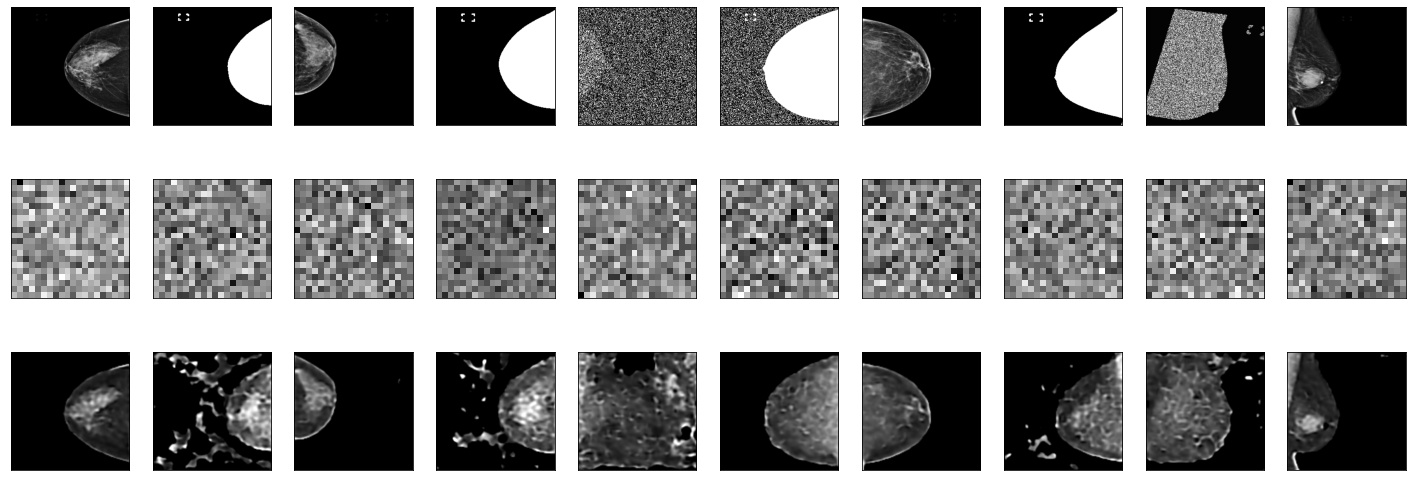

In [19]:
with torch.no_grad():
    mixed_set_g = np.stack(mixed_set).reshape(mixed_set_scale,height,width,1).repeat(3,3)
    mixed_recon_g = np.stack(mixed_reconstruction_set).reshape(mixed_set_scale,height,width,1).repeat(3,3)
    print(mixed_set_g.shape)
    print(mixed_recon_g.shape)

    #number = mixed_set_scale
    number = 10
    plt.figure(figsize=(25, 9))
    for index in range(number):
        # display original
        ax = plt.subplot(3, number, index + 1)
        test_examples = mixed_set_g
        copyback = test_examples[index]
        print(copyback.shape)
        plt.imshow(copyback)
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display codes
        ax = plt.subplot(3, number, index + number + 1)
        codes = mixed_code_set
        code_copyback = codes[index].cpu()
        plt.imshow(code_copyback.reshape(code_sides[0],code_sides[0]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, number, index + (number*2) + 1)
        reconstruction = mixed_recon_g
        recon_copyback = reconstruction[index]
        plt.imshow(recon_copyback)
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    out_path = "adv_output"+ str(width) + "_"  + str(code_sides[0]) + "_" + str(convolution_filters) + "_" + str(dropout_rate) + "_" + str(l2_decay) +".png"
    plt.savefig(out_path)
    plt.show()

And plot the failures from the MSE calculation:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


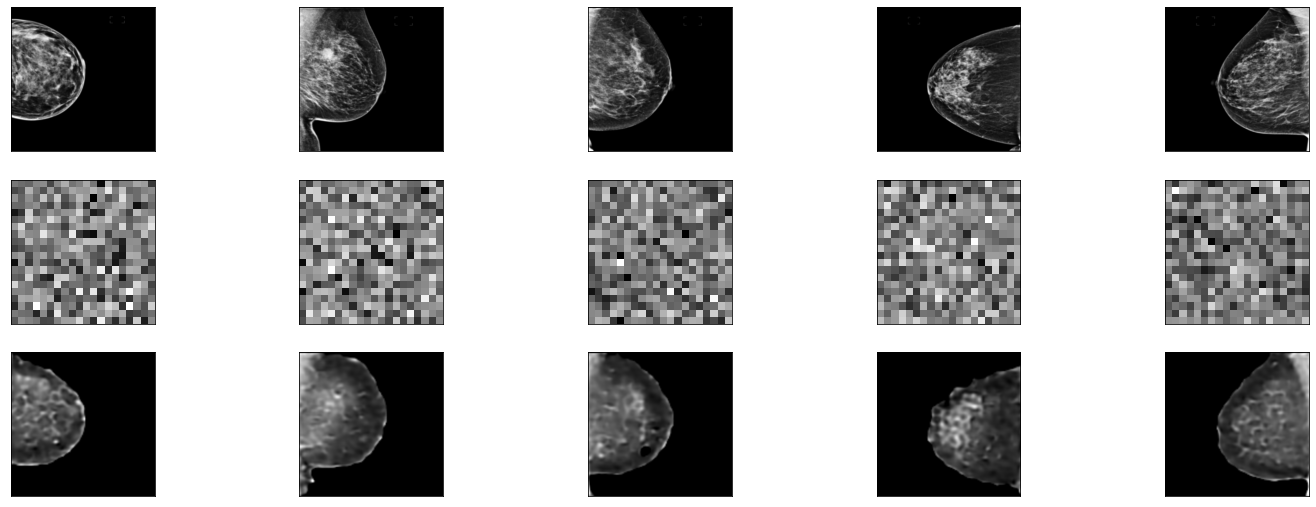

In [20]:
with torch.no_grad():

    #number = mixed_set_scale
    number = len(fails[0])
    plt.figure(figsize=(25, 9))
    for index in range(number):
        image_index = fails[0][index]
        # display original
        ax = plt.subplot(3, number, index + 1)
        test_examples = mixed_set_g
        copyback = test_examples[image_index]
        print(copyback.shape)
        plt.imshow(copyback)
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display codes
        ax = plt.subplot(3, number, index + number + 1)
        codes = mixed_code_set
        code_copyback = codes[image_index].cpu()
        plt.imshow(code_copyback.reshape(code_sides[0],code_sides[0]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, number, index + (number*2) + 1)
        reconstruction = mixed_recon_g
        recon_copyback = reconstruction[image_index]
        plt.imshow(recon_copyback)
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    out_path = "fail_output"+ str(width) + "_"  + str(code_sides[0]) + "_" + str(convolution_filters) + "_" + str(dropout_rate) + "_" + str(l2_decay) +".png"
    plt.savefig(out_path)
    plt.show()

Finally, plot projected error against reconstructed MSE:

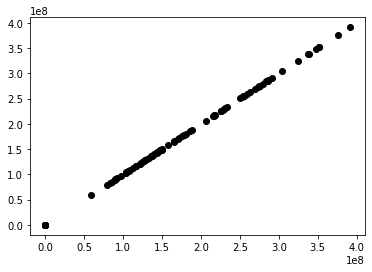

In [21]:
#print(mse_max)

#adv_indexes = np.where(mixed_class_np==0)

#mixed_error_set_np = np.stack(mixed_error_set)[adv_indexes]

#fixed_indexes = np.where(mixed_error_set_np < 1.0)

#fixed_before_error = mixed_error_set_np[fixed_indexes]
#fixed_after_error = np_post_losses[fixed_indexes]

#before_log_error = np.log(fixed_before_error)
#after_log_error = np.log(fixed_after_error)
#print(fixed_before_error)
#print(fixed_after_error)
plt.plot(mixed_error_set, np_post_losses, 'o', color='black');